# Valley analysis in LSDTopoTools

Welcome to `plot-valley-analysis`! In order to run this notebook you need to have followed the installation instructions on the `lsdtt-notebooks` GitHub repository and make sure you have `lsdviztools` installed. This notebook plots the results of the LSDTopoTools valley analysis code. It will produce map plots of the valley defined from LSDTT. It also has a number of different options depending on what you're interested in doing. 

If you chose to run the terrace extraction it will make:
* Separate map plots of the floodplain and the terraces

If you chose to measure valley width it will make:
* Plots of the valley width vs distance downstream
* Map plots of the valley width measurements

**NOTE: This is a work in progress!** 

--------------------------------------------------

**If you use this code please cite**: Clubb, F. J., Mudd, S. M., Milodowski, D. T., Valters, D. A., Slater, L. J., Hurst, M. D., and Limaye, A. B.: Geomorphometric delineation of floodplains and terraces from objectively defined topographic thresholds, Earth Surf. Dynam., 5, 369–385, https://doi.org/10.5194/esurf-5-369-2017, 2017.

--------------------------------------------------


# Package imports and declaring variables

Import required and packages and define the data directory and DEM name here

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, MultiLineString
from pyproj import Transformer
import os
import numpy as np
from scipy.spatial import cKDTree



# import some lsdtt modules\
# import lsdviztools.lsdbasemaptools as bmt
# from lsdviztools.lsdplottingtools import lsdmap_gdalio as gio
# import lsdviztools.lsdmapwrappers as lsdmw
# import lsdttparamselector as ps

Let's define the data directory and the prefix of your DEM. **The path to the folder MUST have a '/' at the end.**

In [2]:
DataDirectory = '/mnt/c/Users/eliot/Linux/DEMS/Switzerland/Birs/Valley_Centreline/Birs_Test11_180621/'
Base_file = "Birs_T11_Clipped"

# Valley plotting

This section makes map plot of the valley. First we'll read in the valley raster and make a plot against the shaded relief.

**NOTE: this is commented out at the moment due to issues with pip version of lsdviztools**

In [3]:
# %matplotlib inline
# Drape_prefix = Base_file+"_valley"
# valley_img = lsdmw.BinaryDrape(DataDirectory,Base_file, Drape_prefix, cmap = "GnBu_r", alpha=1, save_fig=True)

# Valley width

In this section we'll make some plots of  the valley width against distance.

In [7]:
# Read in the valley width geojson
widths = gpd.read_file(DataDirectory+Base_file+'_valley_widths.geojson')
widths = widths[widths['total_valley_width'] > 0]

In [8]:
# get the mean valley width
mean_width = widths['total_valley_width'].mean()

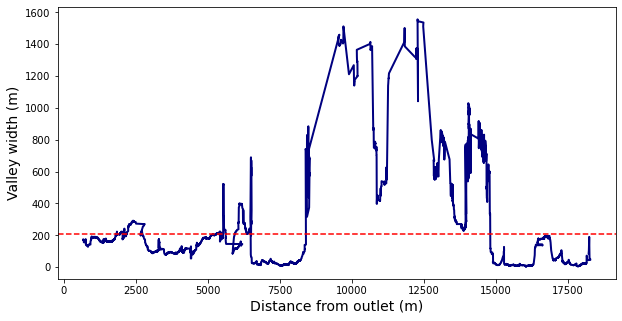

In [9]:
# plot the raw width data
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax.plot(widths['distance_from_outlet'], widths['total_valley_width'], c='navy', lw=2)
ax.axhline(mean_width, ls='--', c='r')
ax.set_xlabel('Distance from outlet (m)', fontsize=14)
ax.set_ylabel('Valley width (m)', fontsize=14)
plt.show()

In [10]:
# make a plot of the rolling average of widths

In [11]:
reach_length = 100    # set the reach length to average over in metres
widths['rolling_width'] = widths.rolling(reach_length, center=True).mean()['total_valley_width']
widths['rolling_width_std'] = widths.rolling(reach_length, center=True).std()['total_valley_width']
widths['dist_downstream'] = widths['distance_from_outlet'].max() - widths['distance_from_outlet']

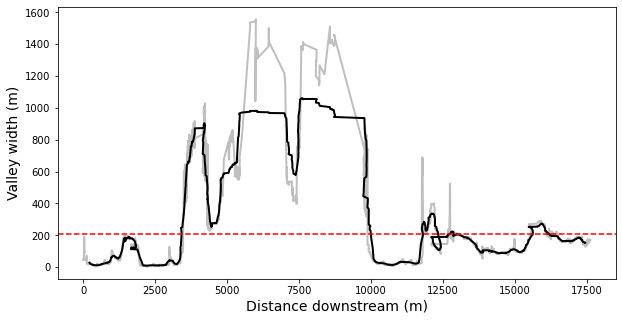

In [12]:
# plot the rolling width data
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax.plot(widths['dist_downstream'], widths['total_valley_width'], c='0.5', lw=2, alpha=0.5)
ax.plot(widths['dist_downstream'], widths['rolling_width'], c='k', lw=2)
ax.axhline(mean_width, ls='--', c='red')
ax.set_xlabel('Distance downstream (m)', fontsize=14)
ax.set_ylabel('Valley width (m)', fontsize=14)
plt.show()

In [13]:
fig.savefig(DataDirectory+Base_file+"_widths.png", dpi=300, transparent=False, facecolor='white')

# Plotting a single reach along the valley centreline
This section is useful if you have run the code in tiles and want to make a composite plot of the valley width along the full valley. You will need a merged centreline of the valley as a line shapefile.

In [14]:
# Read in the valley width geojson
widths = gpd.read_file(DataDirectory+Base_file+'_valley_widths.geojson')
widths = widths[widths['total_valley_width'] > 0]

In [15]:
# name and path of the merged centreline
centreline_shp = '/mnt/c/Users/eliot/Linux/DEMS/Switzerland/Birs/Valley_Centreline/Birs_valley_centreline_final.shp'
# the UTM EPSG code of your region. You need to set this so we can get the correct distances in metres.
UTM_EPSG_code = 'epsg:32632'

In [16]:
# now read in the centreline to a geopandas geodataframe
centreline = gpd.read_file(centreline_shp)

# get the centreline in UTM
centreline_utm = centreline.to_crs(UTM_EPSG_code)
# set up the pyproj transformer
transformer = Transformer.from_crs("epsg:4326", UTM_EPSG_code)

In [17]:
# get the distance of the widths along the line
def get_distance_along_line(row):
    #point = Point(row['longitude'], row['latitude'])
    # convert the point to UTM
    point = Point(transformer.transform(row['latitude'], row['longitude']))
    # getting the distance of the point along the line
    distance = centreline_utm.project(point)
    return(distance)
    
widths['centreline_dist'] = widths.apply(get_distance_along_line, axis=1)

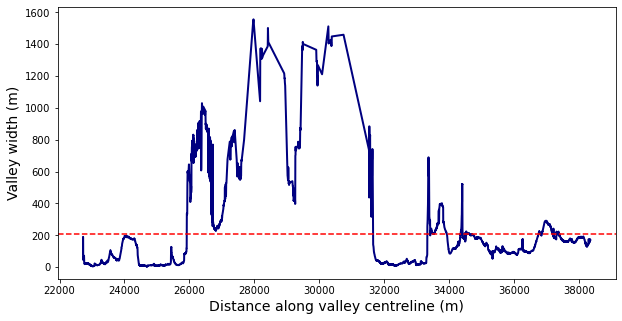

In [18]:
# make a plot of the valley width vs. distance along the merged centreline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax.plot(widths['centreline_dist'], widths['total_valley_width'], c='navy', lw=2)
ax.axhline(mean_width, ls='--', c='r')
ax.set_xlabel('Distance along valley centreline (m)', fontsize=14)
ax.set_ylabel('Valley width (m)', fontsize=14)
plt.show()

# Plotting all the reaches along the valley centreline
In this section we will loop through all the directories in your subfolder and make a composite plot of the widths for each one.

In [19]:
# define the name of the base directory that you want to loop through
base_dir = '/mnt/c/Users/eliot/Linux/DEMS/Switzerland/Birs/Valley_Centreline/'
#base_dir = '/media/TopographicData/TopographicData/valley_width/Switzerland/Birs/Valley_Centreline/'
# the name of the centreline shapefile - I am assuming it is located in the base directory
centreline_shp = base_dir+'Birs_valley_centreline_final.shp'
# the UTM EPSG code of your region. You need to set this so we can get the correct distances in metres.
UTM_EPSG_code = 'epsg:32632'

In [20]:
# now read in the centreline to a geopandas geodataframe
centreline = gpd.read_file(centreline_shp)
#centreline = centreline.dissolve()

# get the centreline in UTM
centreline_utm = centreline.to_crs(UTM_EPSG_code)
# set up the pyproj transformer
transformer = Transformer.from_crs("epsg:4326", UTM_EPSG_code)

# set up the master dataframe for storing all the width data together
widths = gpd.GeoDataFrame()

In [21]:
centreline

,path,begin,end,geometry
0,Birs_T10_centreline_nodes.shp|layername=Birs_T...,2302570.0,9203750.0,"MULTILINESTRING ((7.21785 47.23365, 7.21787 47..."


In [22]:
# get the distance of the widths along the line. This just defines the code that will do this, but won't actually
# do anything until the next block.
def get_distance_along_line(row):
    #point = Point(row['longitude'], row['latitude'])
    # convert the point to UTM
    point = Point(transformer.transform(row['latitude'], row['longitude']))
    # getting the distance of the point along the line
    distance = centreline_utm.project(point)
    return(distance)

In [23]:
# loop through the subdirectories and read in the valley width geojsons, calculate the distance along the centreline
# and write to a new geodataframe. This might be slow!
for root, subdirs, files in os.walk(base_dir):
    for file in files:
        if '_valley_widths.geojson' in file:
            this_gdf = gpd.read_file(os.path.join(root,file))
            this_gdf = this_gdf[this_gdf['total_valley_width'] > 0]
            #this_gdf = this_gdf.drop(columns=['distance_from_outlet', 'node'])
            this_gdf['centreline_dist'] = this_gdf.apply(get_distance_along_line, axis=1)
            widths = widths.append(this_gdf, ignore_index=True)

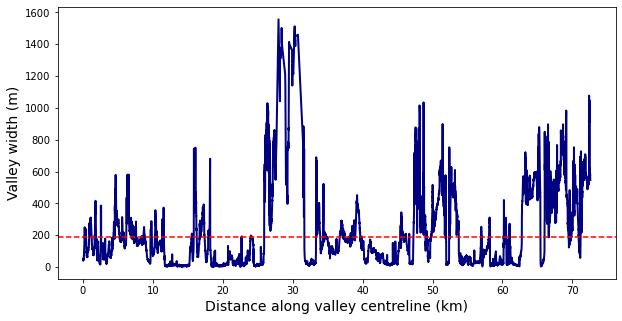

In [24]:
# sort by the distance along the centreline to make sure we're plotting in the right order
widths = widths.sort_values(by='centreline_dist')

# get the mean valley width
mean_width = widths['total_valley_width'].mean()

# make a plot of the valley width vs. distance along the merged centreline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax.plot(widths['centreline_dist']/1000, widths['total_valley_width'], c='navy', lw=2)
ax.axhline(mean_width, ls='--', c='r')
ax.set_xlabel('Distance along valley centreline (km)', fontsize=14)
ax.set_ylabel('Valley width (m)', fontsize=14)
plt.show()
fig.savefig(base_dir+'Birs_valley_width.png', transparent=False)

In [25]:
widths

,latitude,longitude,distance_from_outlet,flow_bearing,left_valley_width,node,orthogonal_bearing,right_valley_width,total_valley_width,geometry,centreline_dist
26390,47.233746,7.218067,13826.981400,57.653317,20.628973,7352453,147.653320,20.628973,43.257526,"LINESTRING (7.21807 47.23375, 7.21809 47.23376)",22.711352
26391,47.233764,7.218092,13826.981400,55.882774,20.628973,7345183,145.882782,22.319118,44.934971,"LINESTRING (7.21809 47.23376, 7.21812 47.23378)",25.536874
26392,47.233783,7.218118,13824.153300,56.583839,20.628973,7337913,146.583832,22.319118,44.934971,"LINESTRING (7.21812 47.23378, 7.21814 47.23378)",28.246703
26393,47.233783,7.218145,13822.153300,59.753937,25.071543,7337914,149.753937,20.628973,47.697422,"LINESTRING (7.21814 47.23378, 7.21817 47.23380)",30.377649
26394,47.233802,7.218170,13819.325200,59.747536,19.587145,7330644,149.747528,22.319118,43.899773,"LINESTRING (7.21817 47.23380, 7.21820 47.23382)",33.178591
...,...,...,...,...,...,...,...,...,...,...,...
26385,47.538601,7.620718,823.081970,45.000000,389.199646,615638,135.000000,160.169617,551.368652,"LINESTRING (7.62072 47.53860, 7.62074 47.53860)",72556.237369
26386,47.538601,7.620745,822.253845,46.663700,390.820099,615639,136.663696,161.638702,554.455811,"LINESTRING (7.62074 47.53860, 7.62077 47.53862)",72558.248059
26387,47.538619,7.620771,825.081360,46.663700,390.820099,613214,136.663696,158.812149,551.629578,"LINESTRING (7.62077 47.53862, 7.62080 47.53864)",72561.083097
26388,47.538638,7.620797,827.908875,46.663700,392.189911,610789,136.663696,155.985626,550.174744,"LINESTRING (7.62080 47.53864, 7.62082 47.53866)",72563.917741


## Bedrock geology

Add the plotting of the bedrock geology. We will load in the geology shapefile to a dataframe of polygons using geopandas. For each point along the valley centreline, we'll look to see if it intersects one of the polygons and assign it the appropriate bedrock type.

In [26]:
# read in the geology shapefile to a geopandas geodataframe
# geology_gdf = gpd.read_file('/mnt/c/Users/eliot/Linux/DEMS/Switzerland/Birs/Valley_Centreline/Geological_Investigation/Birs_Bedrock_Merged_4.shp')
#geology_gdf = gpd.read_file('/media/TopographicData/TopographicData/valley_width/Switzerland/Birs/Geology/Birs_Bedrock_Merged.shp')

In [27]:
# this is how you can check the coordinate system of a geodataframe.
# geology_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
# change to UTM so we can do the buffering in metres
# widths_utm = widths.to_crs(UTM_EPSG_code)
# buffer each part of the centreline to create a polygon that's 150 m in width
# widths_utm['centreline_buffer'] = widths_utm['geometry'].buffer(150)
# convert back to WGS84
# widths_utm['geometry'] = widths_utm['centreline_buffer']
# buffered_widths = widths_utm.to_crs('epsg:4326')

NameError: name 'widths' is not defined

In [50]:
# buffered_widths

,latitude,longitude,distance_from_outlet,flow_bearing,left_valley_width,node,orthogonal_bearing,right_valley_width,total_valley_width,geometry,centreline_dist,centreline_buffer
26390,47.233746,7.218067,13826.981400,57.653317,20.628973,7352453,147.653320,20.628973,43.257526,"POLYGON ((7.22005 47.23378, 7.22004 47.23364, ...",22.711352,"POLYGON ((365271.117 5232679.997, 365270.395 5..."
26391,47.233764,7.218092,13826.981400,55.882774,20.628973,7345183,145.882782,22.319118,44.934971,"POLYGON ((7.22007 47.23380, 7.22007 47.23366, ...",25.536874,"POLYGON ((365273.113 5232681.997, 365272.391 5..."
26392,47.233783,7.218118,13824.153300,56.583839,20.628973,7337913,146.583832,22.319118,44.934971,"POLYGON ((7.22010 47.23381, 7.22009 47.23368, ...",28.246703,"POLYGON ((365275.109 5232683.998, 365274.387 5..."
26393,47.233783,7.218145,13822.153300,59.753937,25.071543,7337914,149.753937,20.628973,47.697422,"POLYGON ((7.22013 47.23381, 7.22012 47.23368, ...",30.377649,"POLYGON ((365277.131 5232683.996, 365276.409 5..."
26394,47.233802,7.218170,13819.325200,59.747536,19.587145,7330644,149.747528,22.319118,43.899773,"POLYGON ((7.22015 47.23383, 7.22015 47.23370, ...",33.178591,"POLYGON ((365279.091 5232685.997, 365278.369 5..."
...,...,...,...,...,...,...,...,...,...,...,...,...
26385,47.538601,7.620718,823.081970,45.000000,389.199646,615638,135.000000,160.169617,551.368652,"POLYGON ((7.62271 47.53862, 7.62270 47.53849, ...",72556.237369,"POLYGON ((396348.580 5265941.504, 396347.857 5..."
26386,47.538601,7.620745,822.253845,46.663700,390.820099,615639,136.663696,161.638702,554.455811,"POLYGON ((7.62274 47.53863, 7.62273 47.53849, ...",72558.248059,"POLYGON ((396350.590 5265941.501, 396349.868 5..."
26387,47.538619,7.620771,825.081360,46.663700,390.820099,613214,136.663696,158.812149,551.629578,"POLYGON ((7.62276 47.53864, 7.62276 47.53851, ...",72561.083097,"POLYGON ((396352.600 5265943.500, 396351.877 5..."
26388,47.538638,7.620797,827.908875,46.663700,392.189911,610789,136.663696,155.985626,550.174744,"POLYGON ((7.62279 47.53866, 7.62278 47.53853, ...",72563.917741,"POLYGON ((396354.610 5265945.499, 396353.888 5..."


In [51]:
# find if each centreline polygon intserects the geology. To do this we use what's called a "spatial join"
# it will join the polygon from the geology shapefile with the widths dataframe if they intersect in geographic space.
# widths_plus_geology = gpd.sjoin(buffered_widths, geology_gdf, how='left', op='intersects')

In [52]:
# geopandas doesn't like it if there is more than one column with a shape in it. so let's remove the buffered shapes.
# widths_plus_geology = widths_plus_geology.drop(columns=('centreline_buffer'))

In [53]:
# let's write the new dataframe to a shapefile so we can load it in to QGIS and test if it worked
# widths_plus_geology.to_file('/mnt/c/Users/eliot/Linux/DEMS/Switzerland/Birs/Valley_Centreline/Geological_Investigation/Birs_widths_plus_geology.shp')

<ipython-input-53-902b54bc7421>:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  widths_plus_geology.to_file('/mnt/c/Users/eliot/Linux/DEMS/Switzerland/Birs/Valley_Centreline/Geological_Investigation/Birs_widths_plus_geology.shp')


In [28]:
# Reload this file as all nullified values are manually changed to '0' through QGIS
widths_plus_geology = gpd.read_file('/mnt/c/Users/eliot/Linux/DEMS/Switzerland/Birs/Valley_Centreline/Geological_Investigation/Birs_widths_plus_geology.shp')

In [29]:
widths_plus_geology

,latitude,longitude,distance_f,flow_beari,left_valle,node,orthogonal,right_vall,total_vall,centreline,index_righ,SYMBOL,layer,path,LITHOLOGY,a,geometry
0,47.233746,7.218067,13826.981400,57.653317,20.628973,7352453,147.653320,20.628973,43.257526,22.711352,164.0,15200341,Bedrock_147_Dissolved,"C:/Users/eliot/Durham University/CLUBB, FIONA ...",M,None,"POLYGON ((7.22005 47.23378, 7.22004 47.23364, ..."
1,47.233764,7.218092,13826.981400,55.882774,20.628973,7345183,145.882782,22.319118,44.934971,25.536874,164.0,15200341,Bedrock_147_Dissolved,"C:/Users/eliot/Durham University/CLUBB, FIONA ...",M,None,"POLYGON ((7.22007 47.23380, 7.22007 47.23366, ..."
2,47.233783,7.218118,13824.153300,56.583839,20.628973,7337913,146.583832,22.319118,44.934971,28.246703,164.0,15200341,Bedrock_147_Dissolved,"C:/Users/eliot/Durham University/CLUBB, FIONA ...",M,None,"POLYGON ((7.22010 47.23381, 7.22009 47.23368, ..."
3,47.233783,7.218145,13822.153300,59.753937,25.071543,7337914,149.753937,20.628973,47.697422,30.377649,164.0,15200341,Bedrock_147_Dissolved,"C:/Users/eliot/Durham University/CLUBB, FIONA ...",M,None,"POLYGON ((7.22013 47.23381, 7.22012 47.23368, ..."
4,47.233802,7.218170,13819.325200,59.747536,19.587145,7330644,149.747528,22.319118,43.899773,33.178591,164.0,15200341,Bedrock_147_Dissolved,"C:/Users/eliot/Durham University/CLUBB, FIONA ...",M,None,"POLYGON ((7.22015 47.23383, 7.22015 47.23370, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57327,47.538601,7.620718,823.081970,45.000000,389.199646,615638,135.000000,160.169617,551.368652,72556.237369,NaN,None,None,None,0,None,"POLYGON ((7.62271 47.53862, 7.62270 47.53849, ..."
57328,47.538601,7.620745,822.253845,46.663700,390.820099,615639,136.663696,161.638702,554.455811,72558.248059,NaN,None,None,None,0,None,"POLYGON ((7.62274 47.53863, 7.62273 47.53849, ..."
57329,47.538619,7.620771,825.081360,46.663700,390.820099,613214,136.663696,158.812149,551.629578,72561.083097,NaN,None,None,None,0,None,"POLYGON ((7.62276 47.53864, 7.62276 47.53851, ..."
57330,47.538638,7.620797,827.908875,46.663700,392.189911,610789,136.663696,155.985626,550.174744,72563.917741,NaN,None,None,None,0,None,"POLYGON ((7.62279 47.53866, 7.62278 47.53853, ..."


# Valley width vs drainage area

In [30]:
# get the channel centreline
channel_df = gpd.read_file('/mnt/c/Users/eliot/Linux/DEMS/Switzerland/Birs/Merged_Swiss_DEM/SWISSMERGED_R10_Clipped1_swath_channel.geojson')
channel_df

,latitude,longitude,column,drainagearea(m^2),elevation(m),flowdistance(m),id,row,x,y,geometry
0,47.233602,7.217761,2219,1.599260e+03,732.099000,78217.20000,20175687,3524,365097.624,5232664.5,POINT (7.21776 47.23360)
1,47.233694,7.217890,2220,1.640650e+07,731.881000,78203.10000,20169881,3523,365107.624,5232674.5,POINT (7.21789 47.23369)
2,47.233786,7.218019,2221,1.642960e+07,731.716000,78189.00000,20164075,3522,365117.624,5232684.5,POINT (7.21802 47.23379)
3,47.233788,7.218151,2222,1.643300e+07,731.638000,78179.00000,20164076,3522,365127.624,5232684.5,POINT (7.21815 47.23379)
4,47.233880,7.218280,2223,1.643350e+07,731.572000,78164.80000,20158270,3521,365137.624,5232694.5,POINT (7.21828 47.23388)
...,...,...,...,...,...,...,...,...,...,...,...
6382,47.551537,7.637811,5461,9.110250e+08,0.028278,39.99080,28639,54,397510.124,5267356.5,POINT (7.63781 47.55154)
6383,47.551627,7.637808,5461,9.110250e+08,0.021208,29.99310,22832,53,397510.124,5267366.5,POINT (7.63781 47.55163)
6384,47.551717,7.637806,5461,9.110490e+08,0.014139,19.99540,17025,52,397510.124,5267376.5,POINT (7.63781 47.55172)
6385,47.551807,7.637804,5461,9.110490e+08,0.007069,9.99769,11218,51,397510.124,5267386.5,POINT (7.63780 47.55181)


In [31]:
widths_plus_geology

,latitude,longitude,distance_f,flow_beari,left_valle,node,orthogonal,right_vall,total_vall,centreline,index_righ,SYMBOL,layer,path,LITHOLOGY,a,geometry
0,47.233746,7.218067,13826.981400,57.653317,20.628973,7352453,147.653320,20.628973,43.257526,22.711352,164.0,15200341,Bedrock_147_Dissolved,"C:/Users/eliot/Durham University/CLUBB, FIONA ...",M,None,"POLYGON ((7.22005 47.23378, 7.22004 47.23364, ..."
1,47.233764,7.218092,13826.981400,55.882774,20.628973,7345183,145.882782,22.319118,44.934971,25.536874,164.0,15200341,Bedrock_147_Dissolved,"C:/Users/eliot/Durham University/CLUBB, FIONA ...",M,None,"POLYGON ((7.22007 47.23380, 7.22007 47.23366, ..."
2,47.233783,7.218118,13824.153300,56.583839,20.628973,7337913,146.583832,22.319118,44.934971,28.246703,164.0,15200341,Bedrock_147_Dissolved,"C:/Users/eliot/Durham University/CLUBB, FIONA ...",M,None,"POLYGON ((7.22010 47.23381, 7.22009 47.23368, ..."
3,47.233783,7.218145,13822.153300,59.753937,25.071543,7337914,149.753937,20.628973,47.697422,30.377649,164.0,15200341,Bedrock_147_Dissolved,"C:/Users/eliot/Durham University/CLUBB, FIONA ...",M,None,"POLYGON ((7.22013 47.23381, 7.22012 47.23368, ..."
4,47.233802,7.218170,13819.325200,59.747536,19.587145,7330644,149.747528,22.319118,43.899773,33.178591,164.0,15200341,Bedrock_147_Dissolved,"C:/Users/eliot/Durham University/CLUBB, FIONA ...",M,None,"POLYGON ((7.22015 47.23383, 7.22015 47.23370, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57327,47.538601,7.620718,823.081970,45.000000,389.199646,615638,135.000000,160.169617,551.368652,72556.237369,NaN,None,None,None,0,None,"POLYGON ((7.62271 47.53862, 7.62270 47.53849, ..."
57328,47.538601,7.620745,822.253845,46.663700,390.820099,615639,136.663696,161.638702,554.455811,72558.248059,NaN,None,None,None,0,None,"POLYGON ((7.62274 47.53863, 7.62273 47.53849, ..."
57329,47.538619,7.620771,825.081360,46.663700,390.820099,613214,136.663696,158.812149,551.629578,72561.083097,NaN,None,None,None,0,None,"POLYGON ((7.62276 47.53864, 7.62276 47.53851, ..."
57330,47.538638,7.620797,827.908875,46.663700,392.189911,610789,136.663696,155.985626,550.174744,72563.917741,NaN,None,None,None,0,None,"POLYGON ((7.62279 47.53866, 7.62278 47.53853, ..."


In [32]:
# the code needed to attach the channel_df nodes to the nearest widths nodes (or the other way around...)
def ckdnearest(gdA, gdB, thr=200):

    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)
    gdf = gdf[gdf['dist'] <= thr]

    return gdf



In [33]:
# change the widths geometries to points to allow for the merge
widths_plus_geology = gpd.GeoDataFrame(widths_plus_geology, geometry=gpd.points_from_xy(widths_plus_geology.longitude, widths_plus_geology.latitude), crs='epsg:4326')
widths_plus_geology

,latitude,longitude,distance_f,flow_beari,left_valle,node,orthogonal,right_vall,total_vall,centreline,index_righ,SYMBOL,layer,path,LITHOLOGY,a,geometry
0,47.233746,7.218067,13826.981400,57.653317,20.628973,7352453,147.653320,20.628973,43.257526,22.711352,164.0,15200341,Bedrock_147_Dissolved,"C:/Users/eliot/Durham University/CLUBB, FIONA ...",M,None,POINT (7.21807 47.23375)
1,47.233764,7.218092,13826.981400,55.882774,20.628973,7345183,145.882782,22.319118,44.934971,25.536874,164.0,15200341,Bedrock_147_Dissolved,"C:/Users/eliot/Durham University/CLUBB, FIONA ...",M,None,POINT (7.21809 47.23376)
2,47.233783,7.218118,13824.153300,56.583839,20.628973,7337913,146.583832,22.319118,44.934971,28.246703,164.0,15200341,Bedrock_147_Dissolved,"C:/Users/eliot/Durham University/CLUBB, FIONA ...",M,None,POINT (7.21812 47.23378)
3,47.233783,7.218145,13822.153300,59.753937,25.071543,7337914,149.753937,20.628973,47.697422,30.377649,164.0,15200341,Bedrock_147_Dissolved,"C:/Users/eliot/Durham University/CLUBB, FIONA ...",M,None,POINT (7.21814 47.23378)
4,47.233802,7.218170,13819.325200,59.747536,19.587145,7330644,149.747528,22.319118,43.899773,33.178591,164.0,15200341,Bedrock_147_Dissolved,"C:/Users/eliot/Durham University/CLUBB, FIONA ...",M,None,POINT (7.21817 47.23380)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57327,47.538601,7.620718,823.081970,45.000000,389.199646,615638,135.000000,160.169617,551.368652,72556.237369,NaN,None,None,None,0,None,POINT (7.62072 47.53860)
57328,47.538601,7.620745,822.253845,46.663700,390.820099,615639,136.663696,161.638702,554.455811,72558.248059,NaN,None,None,None,0,None,POINT (7.62074 47.53860)
57329,47.538619,7.620771,825.081360,46.663700,390.820099,613214,136.663696,158.812149,551.629578,72561.083097,NaN,None,None,None,0,None,POINT (7.62077 47.53862)
57330,47.538638,7.620797,827.908875,46.663700,392.189911,610789,136.663696,155.985626,550.174744,72563.917741,NaN,None,None,None,0,None,POINT (7.62080 47.53864)


In [34]:
# call the above code to action and merge
widths_DA = ckdnearest(widths_plus_geology, channel_df)
widths_DA

,latitude,longitude,distance_f,flow_beari,left_valle,node,orthogonal,right_vall,total_vall,centreline,...,longitude,column,drainagearea(m^2),elevation(m),flowdistance(m),id,row,x,y,dist
0,47.233746,7.218067,13826.981400,57.653317,20.628973,7352453,147.653320,20.628973,43.257526,22.711352,...,7.218019,2221,16429600.0,731.716,78189.00,20164075,3522,365117.624,5232684.5,0.000062
1,47.233764,7.218092,13826.981400,55.882774,20.628973,7345183,145.882782,22.319118,44.934971,25.536874,...,7.218151,2222,16433000.0,731.638,78179.00,20164076,3522,365127.624,5232684.5,0.000063
2,47.233783,7.218118,13824.153300,56.583839,20.628973,7337913,146.583832,22.319118,44.934971,28.246703,...,7.218151,2222,16433000.0,731.638,78179.00,20164076,3522,365127.624,5232684.5,0.000033
3,47.233783,7.218145,13822.153300,59.753937,25.071543,7337914,149.753937,20.628973,47.697422,30.377649,...,7.218151,2222,16433000.0,731.638,78179.00,20164076,3522,365127.624,5232684.5,0.000008
4,47.233802,7.218170,13819.325200,59.747536,19.587145,7330644,149.747528,22.319118,43.899773,33.178591,...,7.218151,2222,16433000.0,731.638,78179.00,20164076,3522,365127.624,5232684.5,0.000024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57327,47.538601,7.620718,823.081970,45.000000,389.199646,615638,135.000000,160.169617,551.368652,72556.237369,...,7.622081,5340,908895000.0,256.724,2105.98,876340,200,396300.405,5265897.0,0.001416
57328,47.538601,7.620745,822.253845,46.663700,390.820099,615639,136.663696,161.638702,554.455811,72558.248059,...,7.622081,5340,908895000.0,256.724,2105.98,876340,200,396300.405,5265897.0,0.001391
57329,47.538619,7.620771,825.081360,46.663700,390.820099,613214,136.663696,158.812149,551.629578,72561.083097,...,7.622081,5340,908895000.0,256.724,2105.98,876340,200,396300.405,5265897.0,0.001371
57330,47.538638,7.620797,827.908875,46.663700,392.189911,610789,136.663696,155.985626,550.174744,72563.917741,...,7.622081,5340,908895000.0,256.724,2105.98,876340,200,396300.405,5265897.0,0.001351


In [35]:
# make sure all of the lithologies are present
lithology = widths_DA['LITHOLOGY'].unique()

print(lithology)

['M' 'M_LS' '0' 'SS' 'LS' 'C' 'M_SS']


Text(0, 0.5, 'Valley width (m)')

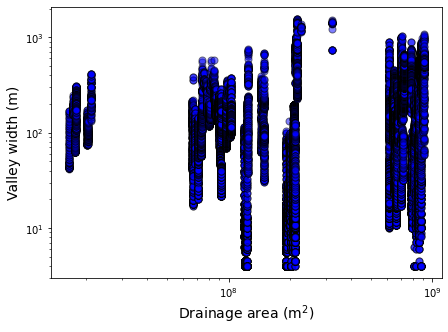

In [36]:
# plot drainage area against total valley width
fig=plt.figure(figsize=(7,5))
plt.scatter(widths_DA['drainagearea(m^2)'], widths_DA['total_vall'], c='blue', edgecolor='k', s=50, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Drainage area (m$^2$)', fontsize=14)
plt.ylabel('Valley width (m)', fontsize=14)

In [38]:
# set specific columns to arrays, this will allow the plot to be coloured to specific lithologies
df = pd.DataFrame({'x': widths_DA['drainagearea(m^2)'],
                   'y': widths_DA['total_vall'],
                   'z': widths_DA['LITHOLOGY']})

In [39]:
df

,x,y,z
0,16429600.0,43.257526,M
1,16433000.0,44.934971,M
2,16433000.0,44.934971,M
3,16433000.0,47.697422,M
4,16433000.0,43.899773,M
...,...,...,...
57327,908895000.0,551.368652,0
57328,908895000.0,554.455811,0
57329,908895000.0,551.629578,0
57330,908895000.0,550.174744,0


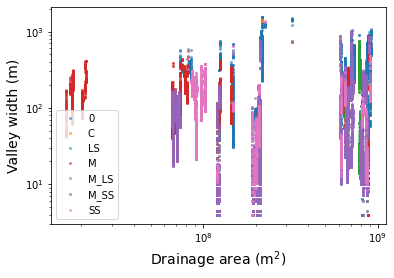

In [40]:
# plot width vs drainage area, coloured to lithology
groups = df.groupby('z')
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', markersize=2, label=name, alpha=0.5)
    plt.xscale('log')
    plt.yscale('log')
    
    plt.xlabel('Drainage area (m$^2$)', fontsize=14)
    plt.ylabel('Valley width (m)', fontsize=14)
plt.legend()


In [42]:
# let's write the new dataframe to a csv to add a column with merged rock hardnesses - LS (Limestone) = Hard, SS (Sandstone) = Med, M_LS (Marl and Limestone) = Med, M_SS (Marl and Sandstone) = Med, C (Clay) = Soft, M (Marl) = Soft, 0 (Unconsolidated) = Soft
widths_DA.to_csv('/mnt/c/Users/eliot/Linux/DEMS/Switzerland/Birs/Valley_Centreline/Geological_Investigation/Birs_widths_DA.csv')

In [43]:
# read in the csv with the new 'HARDNESS' column  
widths_DA_H = pd.read_csv('/mnt/c/Users/eliot/Linux/DEMS/Switzerland/Birs/Valley_Centreline/Geological_Investigation/Birs_widths_DA.csv')

In [44]:
# do the same as above, except this time the plot will be coloured to specific hardnesses
df = pd.DataFrame({'x': widths_DA_H['drainagearea(m^2)'],
                   'y': widths_DA_H['total_vall'],
                   'z': widths_DA_H['HARDNESS']})

In [45]:
df

,x,y,z
0,74050900,380.030640,Soft
1,74050900,427.391205,Soft
2,74050900,406.996826,Soft
3,74050900,460.528931,Soft
4,74050900,487.544983,Soft
...,...,...,...
57327,903419000,188.206161,Med
57328,903419000,190.202744,Med
57329,903419000,190.202744,Med
57330,903419000,192.199371,Med


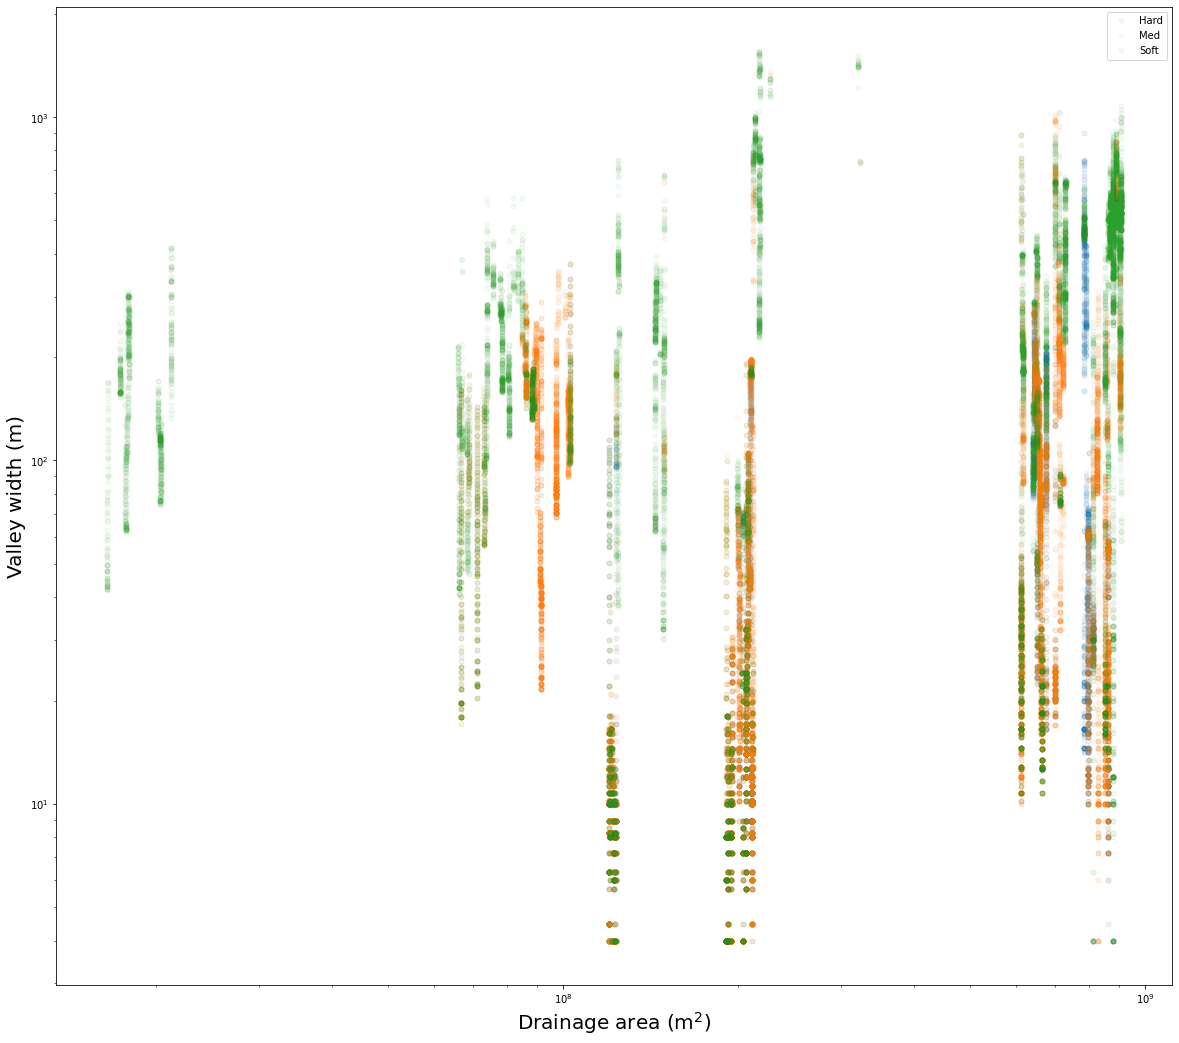

In [50]:
# create new plot
fig=plt.figure(figsize=(20,18))
groups = df.groupby('z')
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', markersize=5, label=name, alpha=0.05)
    plt.xscale('log')
    plt.yscale('log')
   
    
    plt.xlabel('Drainage area (m$^2$)', fontsize=20)
    plt.ylabel('Valley width (m)', fontsize=20)
plt.legend()
